# How do you choose? Software Engineer, Data Scientist, Data Engineer or Data Analyst
## An Analysis of Stackoverflow Developer Survey

### Motivation

As big data became an inseparable part of our daily life, Data science emerged as a new profession and has been gaining increasing popularity ever since. In fact, data centered roles are even more specilized as of now that Data Scientist Data Engineering and Data Analyst are all popular job titles in the market. The fact that most Data related jobs require solid programming skills attracted many Software Engineers' attention for their next potential career move. Students with programming background are also considering data related jobs over traditional software development jobs. Whether you want to make a career change or want to choose your first career, knowing the roles you want to get into is crutial for experienced developers and new grads alike. However, the data related job functions are often not as well defined as Software engineering roles and there are still many part unclear to the eyes of public. This post is done in the hope of finding more insights for these professions from the Stackoverflow survey results provided by current professionals in the field. The questions I wanted to explore are:
### 1. What are the trends in the job market in recent three years? Are data-related jobs rapidly increasing? 
### 2. Are there difference between the four profession in terms of salary?
### 3. Are data-related jobs more stressful than software development jobs?
### 4. What skillset do you need the most for each of the professions?


In [1]:
# align the plot in the center
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from functools import reduce
import warnings

plt.style.use('bmh')
%matplotlib inline

warnings.filterwarnings('ignore')


In [3]:
pd.set_option('display.max_columns', 200)

# import data sets
df_20 = pd.read_csv('../2020 Stack Overflow Survey Responses.csv')
df_19 = pd.read_csv('../2019 Stack Overflow Survey Responses.csv')
df_18 = pd.read_csv('../2018 Stack Overflow Survey Responses.csv')


schema= pd.read_csv('../survey_results_schema.csv')
df_20.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [4]:
df_20.shape

(64461, 61)

In [5]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    # We need to turn it to a list because otherwise it returns a Series object!
    desc = list(schema[schema.Column == column_name]['QuestionText'])[0]
    return desc

In [6]:
get_description('DevType')

'Which of the following describe you? Please select all that apply.'

In [7]:
# get the counts for different developer roles
df_20['DevType'].value_counts()

Developer, full-stack                                                                                                                            4424
Developer, back-end                                                                                                                              3086
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                   2227
Developer, back-end;Developer, full-stack                                                                                                        1476
Developer, front-end                                                                                                                             1401
                                                                                                                                                 ... 
Academic researcher;Developer, back-end;Developer, embedded applications or devices;Developer, QA or

## The respondents could choose multiple roles. We want to get a count for each role type, so we need to do data cleaning on this column.

In [8]:
## code credit: Udacity lesson 1
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [9]:
def clean(df, column_name, possible_vals):
    total=df[column_name].count()  # count non-NA values
    col = df[column_name].value_counts().reset_index()
    col.rename(columns={'index': 'type', column_name: 'count'}, inplace=True)
    count_df = total_count(col, 'type', 'count', possible_vals)
    count_df.set_index('type', inplace=True)
    return count_df/total
    

In [10]:
df_18.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,3-5 years,Extremely satisfied,Extremely satisfied,Working as a founder or co-founder of my own c...,"I’m not actively looking, but I am open to new...",Less than a year ago,10.0,7.0,8.0,1.0,2.0,5.0,3.0,4.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4.0,2.0,5.0,5.0,6.0,7.0,2.0,1.0,4.0,3.0,My job status or other personal status changed,NaN,NaN,Monthly,NaN,KES,Slack,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,To build my professional network,Strongly agree,Strongly agree,Neither Agree nor Disagree,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Linux-based,1,Agile;Scrum,Git,Multiple times per day,Yes,No,NaN,Strongly agree,Strongly agree,Strongly agree,Saw an online advertisement and then researche...,1.0,5.0,4.0,7.0,2.0,6.0,3.0,Artificial intelligence surpassing human intel...,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,No,"Yes, and publicly",Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,I have never participated in Q&A on Stack Over...,"No, I knew that Stack Overflow had a jobs boar...",Yes,NaN,Yes,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,Standing desk,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,Unite

## The proportion of developer roles in 2020

In [11]:
# Clean data for DevType

devtype_vals = ["Academic Researcher", "Data or business analyst", "Data scientist or machine learning specialist",
                 "Database administrator", "Designer", "Developer, full-stack", "Developer, back-end", 
                 "Developer, front-end", "Developer, mobile", "Developer, desktop or enterprise applications",
                 "Developer, embedded applications or devices", "Developer, QA or test", "DevOps specialist",
                 "Developer, game or graphics", "Educator", "Engineering manager", "Engineer, data",
                 "Engineer, site reliability", "Marketing or sales professional", "Product manager", "Scientist",
                 "Senior Executive (CSuite, VP, etc.)", "Student", "System administrator", "Other"]

devtype_df_20 = clean(df_20,'DevType', devtype_vals)  
#devtype_df_20

## The proportion of each developer role in 2019


In [12]:
devtype_df_19 = clean(df_19,'DevType', devtype_vals)   
#devtype_df_19

In [13]:
df_18['DevType'].value_counts()

Back-end developer                                                                                                                                                      6417
Full-stack developer                                                                                                                                                    6104
Back-end developer;Front-end developer;Full-stack developer                                                                                                             4460
Mobile developer                                                                                                                                                        3518
Student                                                                                                                                                                 3222
                                                                                                                                       

### In 2018 survey, some role names are worded differently compared to 2019 and 2020 survey. For example,  "Back-end developer" vs "Developer, Back-end". Made some adjustments to the previous list of role types.

In [14]:
devtype_vals_18 = ["Academic Researcher", "Data or business analyst", "Data scientist or machine learning specialist",
                 "Database administrator", "Designer", "Full-stack developer", "Back-end developer", 
                 "Front-end developer", "Mobile developer", "Desktop or enterprise applications developer",
                 "Embedded applications or devices developer", "QA or test developer", "DevOps specialist",
                 "Game or graphics developer", "Educator", "Engineering manager", "Engineer, data",
                 "Engineer, site reliability", "Marketing or sales professional", "Product manager", "Scientist",
                 "Senior Executive (CSuite, VP, etc.)", "Student", "System administrator", "Other"]


In [15]:
devtype_df_18 = clean(df_18,'DevType', devtype_vals_18)   

### Change the 2018 role type name wording for consistency

In [16]:
devtype_df_18 = devtype_df_18.rename({"Full-stack developer": 'Developer, full-stack', "Back-end developer":'Developer, back-end', "Front-end developer":'Developer, front-end'
                                     ,"Mobile developer": "Developer, mobile", "Desktop or enterprise applications developer": "Developer, desktop or enterprise applications"
                                     , "QA or test developer": "Developer, QA or test", "Embedded applications or devices developer": "Developer, embedded applications or devices", "Game or graphics developer":"Developer, game or graphics"  })


In [17]:
devtype_df_18.rename(columns={'count':'2018'}, inplace=True)
devtype_df_19.rename(columns={'count':'2019'}, inplace=True)
devtype_df_20.rename(columns={'count':'2020'}, inplace=True)


In [18]:
outer_join_df=pd.merge(devtype_df_18, devtype_df_19, on='type', how='outer')
outer_join_df=pd.merge(outer_join_df, devtype_df_20,  on='type', how='outer')
#outer_join_df.rename(columns={'count': '2018', 'count_x' : '2019', 'count_y': '2020'}, inplace=True)
outer_join_df.fillna(0, inplace=True)
# merged the dataframes
outer_join_df

,2018,2019,2020
type,,,
"Developer, back-end",0.578731,0.499969,0.551509
"Developer, full-stack",0.481585,0.519112,0.549423
"Developer, front-end",0.378097,0.327645,0.370589
"Developer, mobile",0.204174,0.180709,0.192060
"Developer, desktop or enterprise applications",0.171632,0.212897,0.238687
Student,0.170818,0.146567,0.000000
Database administrator,0.143499,0.117047,0.115900
Designer,0.130502,0.112891,0.107778
System administrator,0.112652,0.109781,0.106178


## plot

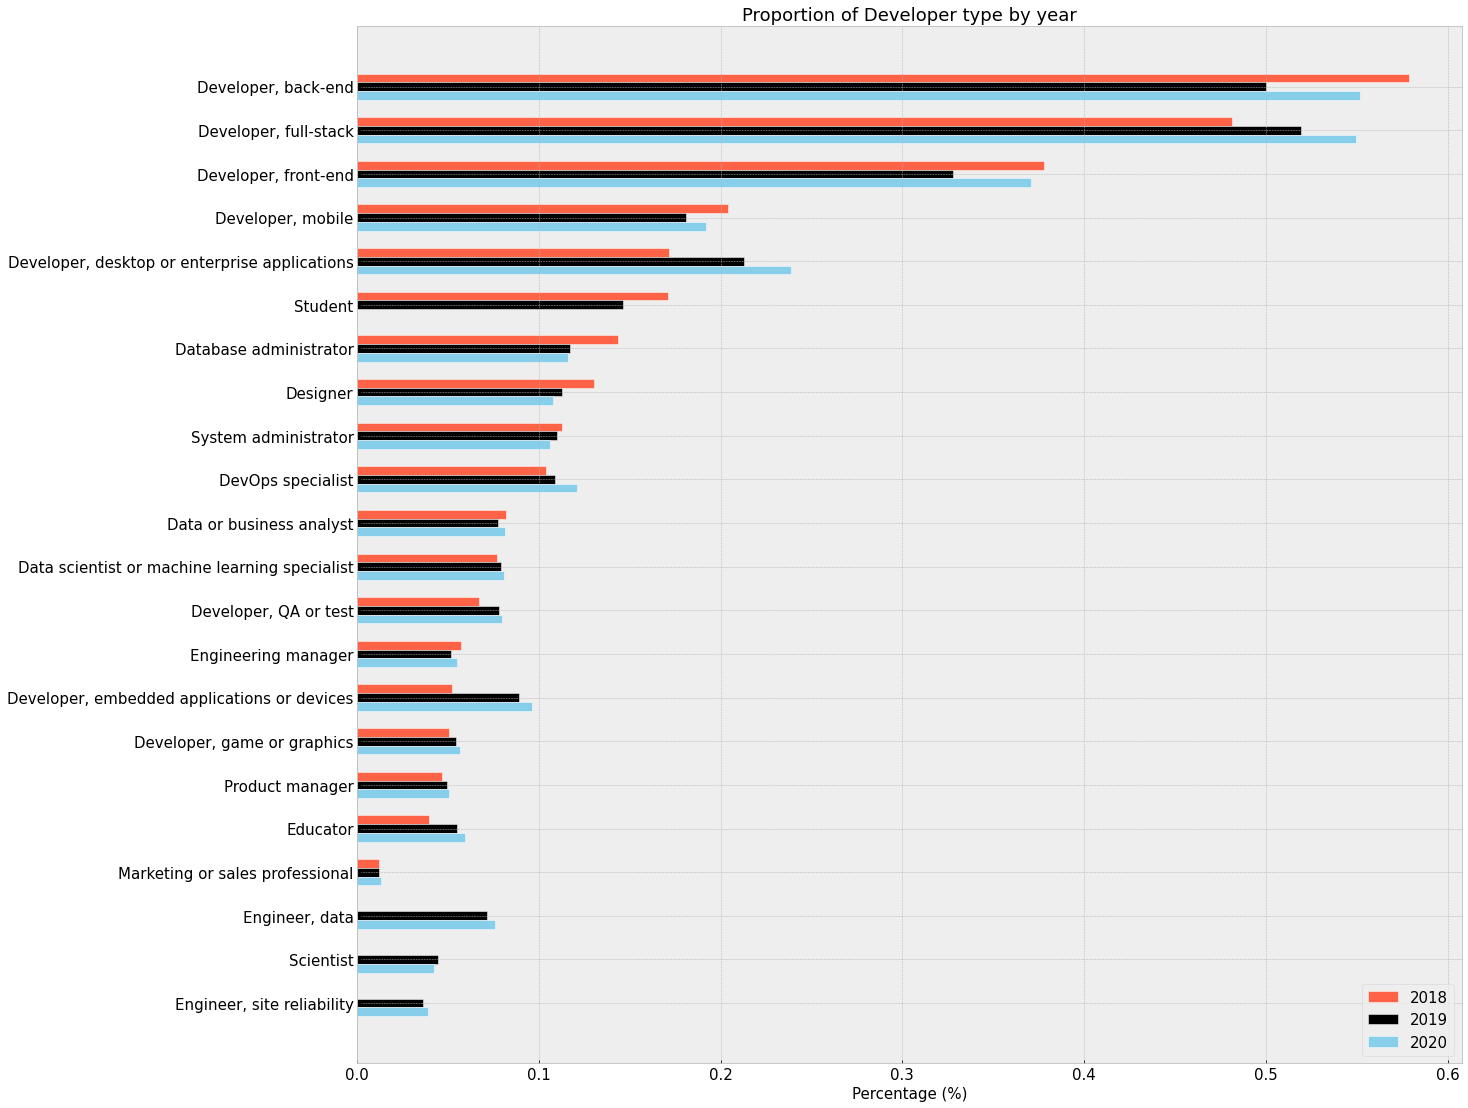

In [40]:
width = 0.40
ind = 2*np.arange(len(outer_join_df))

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 15.5)

ax.barh(ind, outer_join_df['2018'], width, color='tomato',  edgecolor='white', label='2018')
ax.barh(ind+width, outer_join_df['2019'], width, color='black',  edgecolor='white', label='2019')
ax.barh(ind+2*width, outer_join_df['2020'], width, color='skyblue',  edgecolor='white',label='2020')

ax.set(yticks=[r + width for r in ind], yticklabels=outer_join_df.index)
#ax.set_yticklabels(outer_join_df.index)
ax.set_xlabel('Percentage (%)',fontsize=15)
ax.legend(fontsize=15, loc='lower right')
#ax.set_ylabel('Type', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.invert_yaxis()

# recompute the ax.dataLim
ax.relim()

# update ax.viewLim using the new dataLim
#ax.autoscale_view()
plt.title('Proportion of Developer type by year', fontsize=18)
plt.savefig('Proportion of Developer type by year',  bbox_inches = "tight")
plt.tight_layout()
plt.show()


The proportion of developer roles for the past three years is shown above. Notice that each survey respondent could have multiple roles, so the percentages here don't add up to 100%. For example, there are people who marked Data scientist as well as Data analyst since their job involves both roles. Also, some categories have incomplete data: there are some roles that were not included in the 2018 survey such as 'Data Engineer', 'Scientist' and 'Site reliability Engineer'. In 2020, 'Student' option was removed from the survey. 

That being said, we can see from the graph that the jobs that increased the most in the past three years are 'Full-stack Developer', 'Desktop or enterprise applications Developer' and 'Embedded applications or devices Developer'.

The plot shows that the percentage of respondents who are working at a data related role haven't increased much over past three years and the portion is relatively small compared to other developer roles. In 2020, 8.15% reported they work as Data Analyst, 7.57% reported they work as Data Engineer and 8.08% work as Data Scientist. In contrast, there are over 50% of survey respondents said they work as Back-end developer or Full-stack developer, and nearly 40% said they work as Front-end developer. 

## Trend of salary median by developer role over past three years


I will classify the respondents into 4 categories: Data or business analyst, Data scientist or machine learning specialist, Data engineer and Software developer. Here for Software developer, I included all the developer types that contained 'Developer' in its title: Back-end, Full-stack, front-end, mobile, desktop applications, QA or test, embedded devices and game or graphics devices. 

In [20]:
def get_median(df, col):
    df.dropna(subset=[col])
    salary=[]
    
    # get median for Software Developer
    m_sw= df[df['DevType'].str.contains("Developer| developer",na=False)][col].median()

    # Data scientists
    m_ds = df[df['DevType'].str.contains("Data scientist",na=False)][col].median()

    # Data engineers
    m_deng = df[df['DevType'].str.contains("Engineer, data",na=False)][col].median()

    # Data analysts
    m_da = df[df['DevType'].str.contains("analyst",na=False)][col].median()
    
    salary=[m_sw, m_ds, m_deng, m_da]
    
    return salary

df_new_20 = df_20[['DevType','Country', 'ConvertedComp']]
df_new_19 = df_19[['DevType', 'Country','ConvertedComp']]
df_new_18 = df_18[['DevType', 'Country','ConvertedSalary']]


m_2020=get_median(df_new_20,  'ConvertedComp' ) 

m_2019=get_median(df_new_19,  'ConvertedComp' ) 

m_2018=get_median(df_new_18, 'ConvertedSalary' ) 

d={'2020': m_2020, '2019':m_2019, '2018': m_2018}

df_salary=pd.DataFrame(data=d)
df_salary.rename(index={0: 'Software Developer',  1: 'Data Scientist', 2: 'Data Engineer', 3: 'Data Analyst'}, inplace=True)

,2020,2019,2018
Software Developer,52942.0,56076.0,55075.0
Data Scientist,58000.0,61071.0,60000.0
Data Engineer,64859.0,66453.0,NaN
Data Analyst,55129.0,59004.0,58890.5


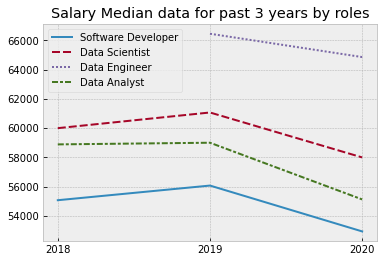

In [21]:
fig, ax = plt.subplots()

ax = sns.lineplot(hue=df_salary.index, data=df_salary.T, style="choice")
plt.title('Salary Median data for past 3 years by roles')
plt.savefig('Salary Median data by roles')
df_salary

The median salary for Data Engineer is the highest among all four professions followed by Data Scientist, Data Analyst and Software Developer respectively. It is interesting to see that the median salaries dropped in all categories in 2020. I speculate this change is due to the fact that stackoverflow had made effort to collect more data outside of US for diversity and since the salaries outside US tend to be lower hence the overall decrease in the salary median. I am interested the salary trends in US, hence I made an analysis only based on the data in US. 

## US Salary median data by developer roles

In [22]:
m_2020=get_median(df_new_20[df_new_20['Country']=='United States'], 'ConvertedComp' ) 

m_2019=get_median(df_new_19[df_new_19['Country']=='United States'], 'ConvertedComp' ) 

m_2018=get_median(df_new_18[df_new_18['Country']=='United States'], 'ConvertedSalary' ) 

d={'US2020': m_2020, 'US2019':m_2019, 'US2018': m_2018}

df_salary_US=pd.DataFrame(data=d)
df_salary_US.rename(index={0: 'Software Developer',  1: 'Data Scientist', 2: 'Data Engineer', 3: 'Data Analyst'}, inplace=True)

,US2020,US2019,US2018
Software Developer,115000.0,110000.0,100000.0
Data Scientist,125000.0,120000.0,102500.0
Data Engineer,125000.0,120000.0,NaN
Data Analyst,100000.0,100000.0,90000.0


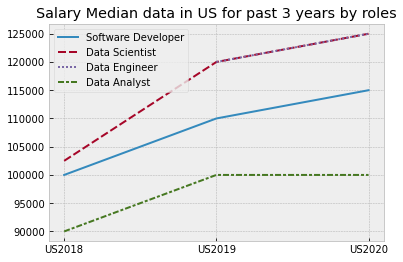

In [23]:
fig, ax = plt.subplots()

ax = sns.lineplot(hue=df_salary_US.index, data=df_salary_US.T)
plt.title('Salary Median data in US for past 3 years by roles')
plt.savefig('Salary Median data in US by roles')

df_salary_US


The median salaries in US for all four professions has been increasing over past three years. Notice, the 2019 and 2020 data used here are total compensations that includes salaries, bonuses and other benefits while the 2018 data only included the annual salary. Hence, the actual salary gap between 2018 and 2019 may not as big as shown in the plot. If we only focus on the data from 2019 to 2020, the median total compensations increased 5k for Data Scientist, Data Engineer and Software Developer while the median total compensation for Data Analysts remain unchanged. Also, the highest paying job in US is Data Scientist and Data Engineer followed by Software Developer and Data Analyst. The median salary for all these professions are greater than or equal 10k since 2019. 

In [24]:
# Software Developer
df_sw = df_20[df_20['DevType'].str.contains("Developer",na=False)]

# Data scientists
df_ds = df_20[df_20['DevType'].str.contains("Data scientist",na=False)]

# Data engineers
df_deng = df_20[df_20['DevType'].str.contains("Engineer, data",na=False)]

# Data analysts
df_da = df_20[df_20['DevType'].str.contains("analyst",na=False)]


# Job Satisfaction by developer type

In [25]:
def get_comparison_df(column_name, needclean=False, possible_vals=None):
    
    # if column needs cleaning, use previous function "clean" to clean data and then count
    if needclean: 
        vals1=clean(df_sw, column_name, possible_vals)
        vals2=clean(df_ds, column_name, possible_vals)
        vals3=clean(df_deng, column_name, possible_vals)
        vals4=clean(df_da, column_name, possible_vals)
        # rename the columns
        vals1=vals1.rename(columns={'count':'SWE'})
        vals2=vals2.rename(columns={'count':'DS'})
        vals3=vals3.rename(columns={'count':'DE'})
        vals4=vals4.rename(columns={'count':'DA'})
        data_frames=[vals1, vals2, vals3, vals4]
        df_merged = reduce(lambda  left,right: pd.merge(left,right, on=['type'],
                                            how='outer'), data_frames)

        
    else:
        vals1 = df_sw[column_name].value_counts(normalize=True).rename('SWE').to_frame()
        vals2 = df_ds[column_name].value_counts(normalize=True).rename('DS').to_frame()
        vals3 = df_deng[column_name].value_counts(normalize=True).rename('DE').to_frame()
        vals4 = df_da[column_name].value_counts(normalize=True).rename('DA').to_frame()

        df_merged=vals1.join(vals2).join(vals3).join(vals4)
    
    return df_merged

In [41]:
def plot_comparison(compare_df, title):
    index = np.arange(compare_df.shape[0])
    bar_width = 0.2

    fig, ax = plt.subplots()

    ax.barh(index, compare_df['SWE'], bar_width,
                        label="Developer", color='dodgerblue')

    ax.barh(index+bar_width, compare_df['DS'],
                         bar_width, label="Data Scientist", color='darkblue')

    ax.barh(index+2*bar_width, compare_df['DE'],
                         bar_width, label="Data Engineer", color='C')

    ax.barh(index+3*bar_width, compare_df['DA'],
                         bar_width, label="Data Analyst", color='cadetblue')
    
    ax.set_xlabel('Percentage (%)',fontsize=15)
    ax.set_title(title, fontsize=20)
    ax.set_yticks(index + 2*bar_width )
    ax.set_yticklabels(compare_df.index)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=15, loc='lower right')
    ax.invert_yaxis()
    plt.savefig(title,  bbox_inches = "tight")
    plt.show()


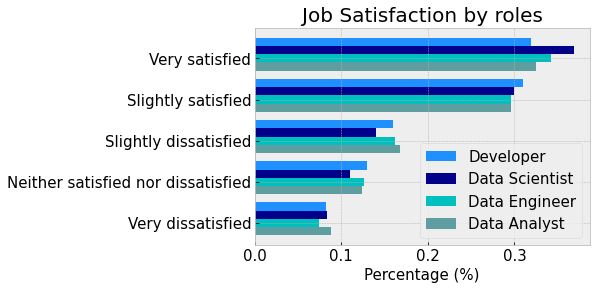

In [42]:
compare_df=get_comparison_df('JobSat')
plot_comparison(compare_df, 'Job Satisfaction by roles')



In terms of Job Satisfaction, about 65% of people answered they were satisfied with their jobs with Data Scientists has the highest Satisfaction rate compared to other professions.

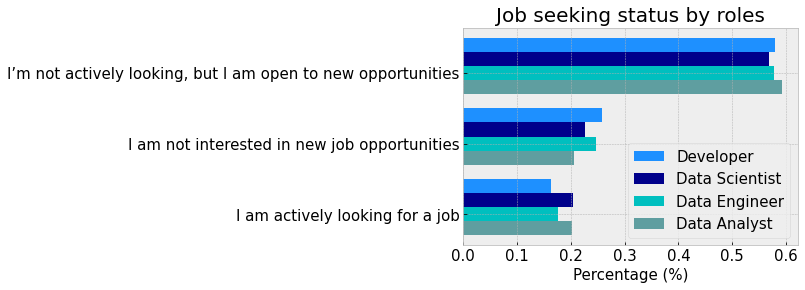

In [43]:
# get job seeking status data by roles
compare_df_js=get_comparison_df('JobSeek')
plot_comparison(compare_df_js, 'Job seeking status by roles')

There are not much difference among the four professions in terms of Job seeking status. About less than 20% of people are actively looking for a job and about 50% answered they are open to new opportunities.

In [29]:
def plot_counts_by_role_group(df, role, title, palette='rocket', ax=None):
    
    """Takes a count-aggregated groupby object, a developer role, and an 
    (optional) AxesSubplot, and draws a barplot for that group."""
    
    sort_order = df[role].sort_values(ascending=False).index[:10]

    sns.barplot(y = df[role].index, 
                x = df[role].values, 
                order = sort_order, 
                palette = palette, 
                edgecolor = 'black', 
                ax = ax
                ).set_title("Top 10 {} Voted by: {}".format(title, role))
    ax.set_ylabel('')    


In [30]:
JobFactors=['Remote work options', 'Office environment or company culture', 'Financial performance or funding status of the company or organization', 'Opportunities for professional development', 'Diversity of the company or organization'
           ,'How widely used or impactful my work output would be', 'Industry that I’d be working in', 'Specific department or team I’d be working on', 'Flex time or a flexible schedule'
           , 'Languages, frameworks, and other technologies I’d be working with', 'Family friendliness']

In [31]:
compare_df_JobF=get_comparison_df('JobFactors', True, JobFactors)

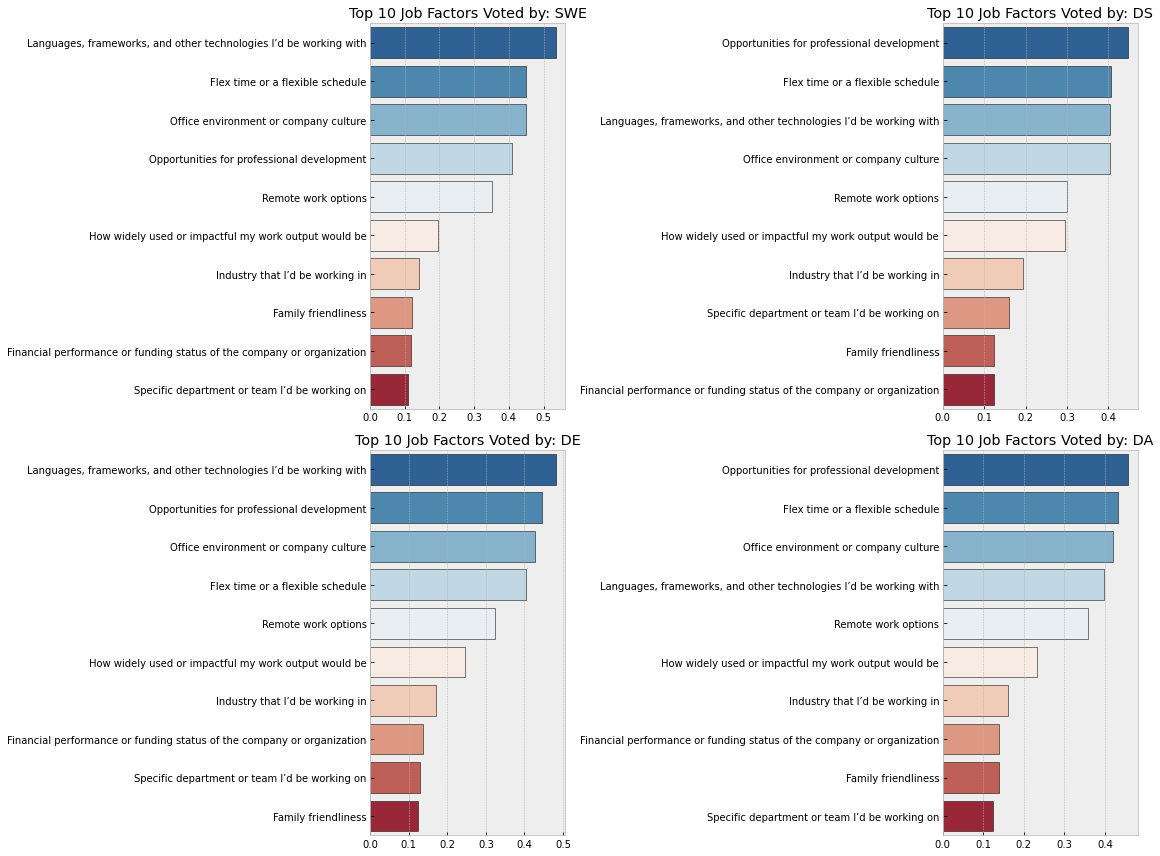

In [44]:
# Setup for the 2x2 subplot grid
# Note we don't want to share the x axis since we have counts
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# ax.flatten() avoids having to explicitly reference a subplot index in ax

for subplot, role in zip(ax.flatten(), ['SWE', 'DS', 'DE', 'DA']):
    plot_counts_by_role_group(compare_df_JobF, role, 'Job Factors', "RdBu_r", ax=subplot)
    
plt.tight_layout()
plt.savefig('10Job Factors',  bbox_inches = "tight")

When it comes to choosing a new job, Software Developers and Data Engineers voted "Languages, frameworks, and other technologies I'd be working with" as the main consideration. In contrary Data Scientists and Data Analysts voted "Opportunities for professional development" as the most important factor. 

## Plot Top 10 languages usage by roles

In [33]:
get_description('LanguageWorkedWith')
lang_type_vals = ['Assembly', 'Bash/Shell/PowerShell', 'C', 'C#', 'C++', 'Dart', 'Go', 'Haskell', 'HTML/CSS', 'Java'
                 ,'JavaScript', 'Julia', 'Kotlin', 'Objective-C', 'Perl', 'PHP', 'Python', 'R', 'Ruby', 'Rust', 'Scala'
                 , 'SQL', 'Swift', 'TypeScript', 'VBA']

In [34]:
compare_df_lang=get_comparison_df('LanguageWorkedWith', True, lang_type_vals)

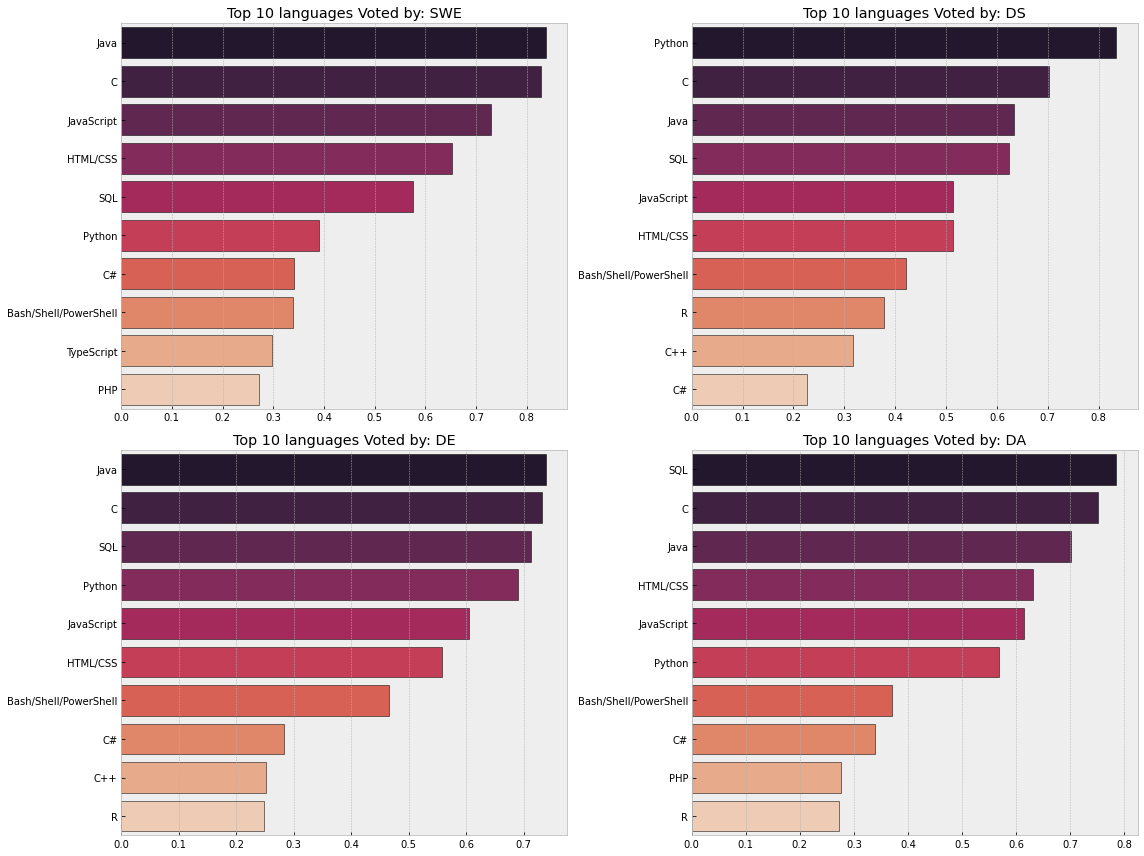

In [45]:
# Setup for the 2x2 subplot grid
# Note we don't want to share the x axis since we have counts
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# ax.flatten() avoids having to explicitly reference a subplot index in ax

for subplot, role in zip(ax.flatten(), ['SWE', 'DS', 'DE', 'DA']):
    plot_counts_by_role_group(compare_df_lang, role, 'languages', ax=subplot)
    
plt.tight_layout()
plt.savefig('10languages',  bbox_inches = "tight")

The most-used language by Software developers and Data Engineers is Java. The most commonly used language by Data Scentists is Python, and the most-used language by Data Analysts is SQL. Interestingly, the second most-used language for all four professions is C. 

## Plot Top 10 Database usage by roles

In [36]:
get_description('DatabaseWorkedWith')
DB_type_vals = ['Cassandra', 'Couchbase', 'DynamoDB', 'Elasticsearch', 'Firebase', 'IBM DB2', 'MariaDB', 'Microsoft SQL Server', 'MongoDB', 'MySQL'
                 , 'Oracle', 'PostgreSQL', 'Redis', 'SQLite'
                ]

In [37]:
compare_df_DB=get_comparison_df('DatabaseWorkedWith', True, DB_type_vals)

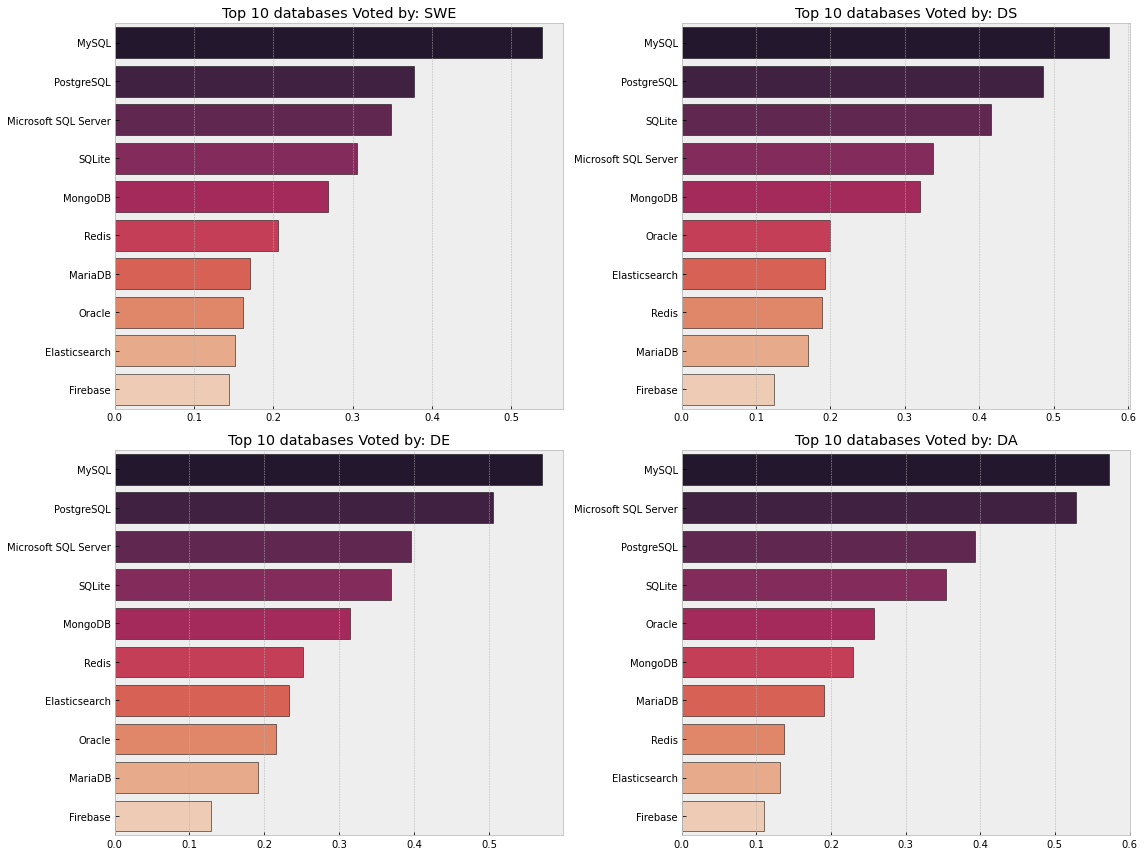

In [46]:
# Setup for the 2x2 subplot grid
# Note we don't want to share the x axis since we have counts
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# ax.flatten() avoids having to explicitly reference a subplot index in ax

for subplot, role in zip(ax.flatten(), ['SWE', 'DS', 'DE', 'DA']):
    plot_counts_by_role_group(compare_df_DB, role, 'databases', ax=subplot)
    
plt.tight_layout()
plt.savefig('10Database',  bbox_inches = "tight")

MySQL has been voted for the top database by all four professions. PostgreSQL is a close second except for Data Analysts, who voted Microsoft SQL server over PostgreSQL.